# USA Projects: Food waste treatment and co-digestion

In [90]:
library(ggplot2)
library(tidyverse)
library(GGally)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)
library(ranger)
library(rpart.plot)
library(gbm)
library(MASS)
library(Benchmarking)

## 1. Data preparation, imputation, and vizualization

#### Data cleaning and imputation

In [92]:
# Read in data
df <- read.csv("DataUSA.csv", na.strings="")

In [93]:
# Change variable types (numeric or factor)
df$Cattle <- as.factor(df$Cattle)
df$Dairy <- as.factor(df$Dairy)
df$Poultry <- as.factor(df$Poultry)
df$Swine <- as.factor(df$Swine)
df$Codigestion <- as.factor(df$Codigestion)
df$CodigestionFW <- as.factor(df$CodigestionFW)


 Variables sorted by number of missings: 
             Variable Count
     ElectricitykWhyr 0.250
 EmissionRedMetricTpy 0.025
          ProjectType 0.000
         DigesterType 0.000
               Cattle 0.000
                Dairy 0.000
              Poultry 0.000
                Swine 0.000
         CattleAmount 0.000
          DairyAmount 0.000
        PoultryAmount 0.000
          SwineAmount 0.000
          Codigestion 0.000
        CodigestionFW 0.000


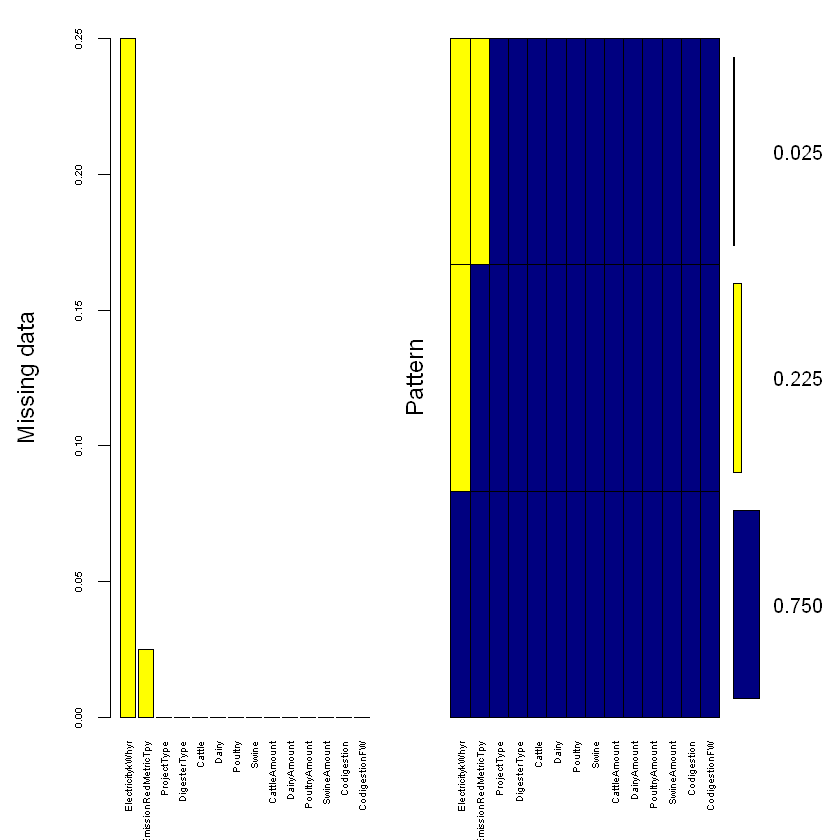

In [95]:
# Test for missing values and visualize  
missVals_plot <- aggr(df, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [97]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


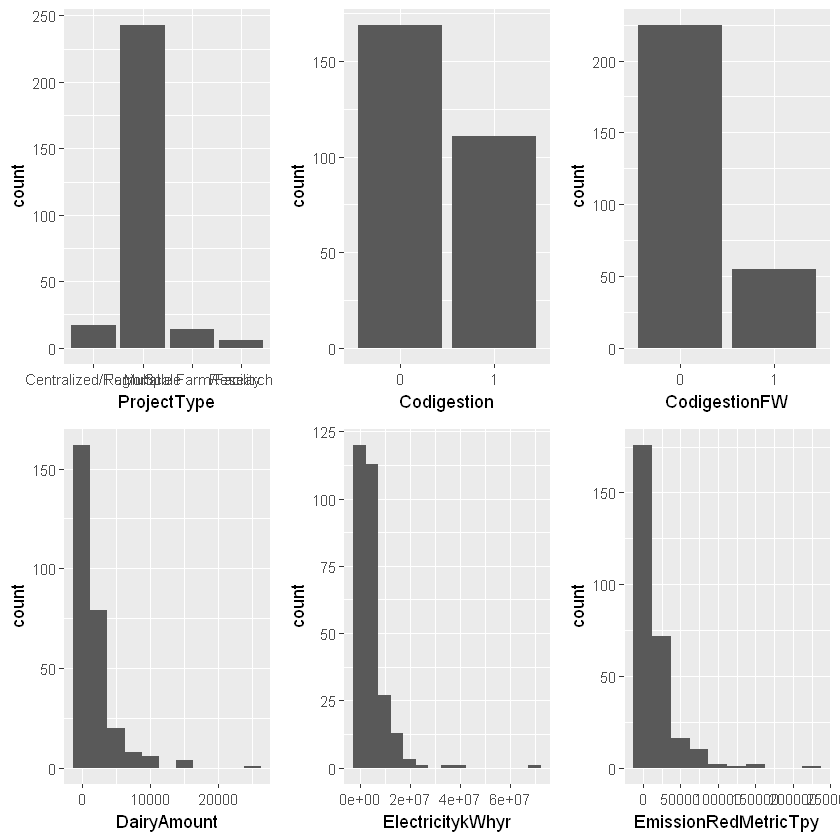

In [117]:
# Visualize the distributions of our variables
h2 <- ggplot(data = df2, aes(x = Codigestion)) + geom_bar()
h3 <- ggplot(data = df2, aes(x = CodigestionFW)) + geom_bar()

h4 <- ggplot(data = df2, aes(x = DairyAmount)) + geom_histogram(binwidth=2500)
h5 <- ggplot(data = df2, aes(x = ElectricitykWhyr)) + geom_histogram(binwidth=5000000)
h6 <- ggplot(data = df2, aes(x = EmissionRedMetricTpy)) + geom_histogram(binwidth=25000)

# Place the plot objects into a grid
grid.arrange(h1,h2,h3,h4,h5,h6,ncol=3)

In [119]:
df2[c("ProjectType","Codigestion",
             "CodigestionFW","DairyAmount",
             "ElectricitykWhyr","EmissionRedMetricTpy")]

ProjectType,Codigestion,CodigestionFW,DairyAmount,ElectricitykWhyr,EmissionRedMetricTpy
Farm Scale,0,0,0,749832.8,4002.00
Farm Scale,0,0,15000,5256000.0,138971.00
Farm Scale,0,0,4000,4467600.0,39353.00
Farm Scale,0,0,15500,16206000.0,108050.00
Farm Scale,0,0,1700,4204800.0,15014.00
Farm Scale,0,0,9700,7600000.0,82693.00
Multiple Farm/Facility,0,0,7000,6700000.0,60585.00
Farm Scale,1,0,1700,1830000.0,13204.00
Farm Scale,0,0,7000,7600000.0,61258.00
Farm Scale,1,0,400,1326978.2,3611.00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


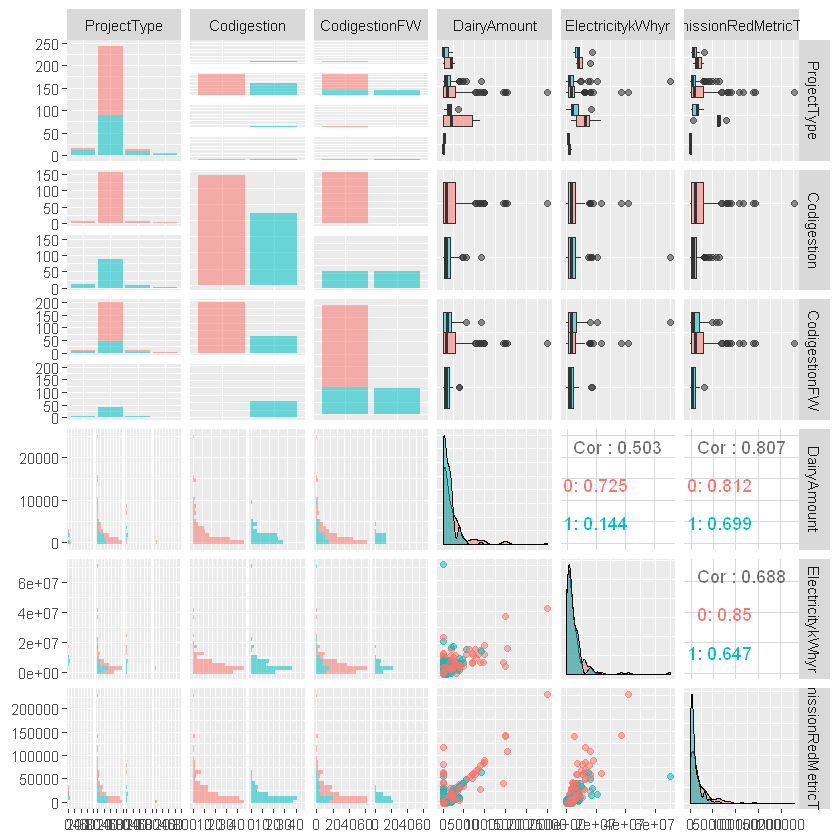

In [121]:
# Pairplot of selected variables:
ggpairs(df2[c("ProjectType","Codigestion",
             "CodigestionFW","DairyAmount",
             "ElectricitykWhyr","EmissionRedMetricTpy")], aes(colour = Codigestion, alpha = 0.4))

## 2. Machine learning

In [ ]:
# Set caret theme
trellis.par.set(caretTheme())

In [122]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

### Random forest model

In [123]:
# We first train a random forest model
set.seed(0)
rf_mod <- train(ElectricitykWhyr ~ ., data = df2[-14], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [124]:
# Model performance summary
rf_mod

Random Forest 

280 samples
 12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 252, 252, 252, 252, 252, 252, ... 
Resampling results across tuning parameters:

  mtry  RMSE     Rsquared   MAE    
   2    5012905  0.3919621  3040719
   5    4546456  0.4911846  2527902
   8    4409953  0.5209924  2332441
  11    4393514  0.5285925  2268343
  14    4419458  0.5296697  2256993
  17    4480057  0.5244342  2281265
  20    4539995  0.5200308  2305509
  24    4625916  0.5128348  2337931

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 11.

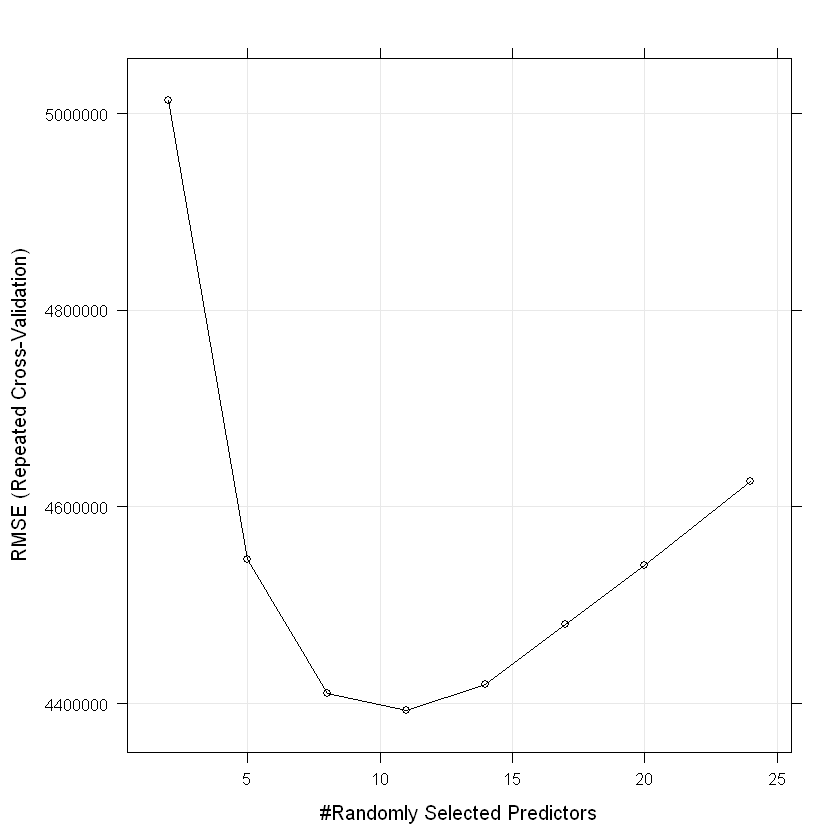

In [125]:
# Plot model training resutls
plot(rf_mod)

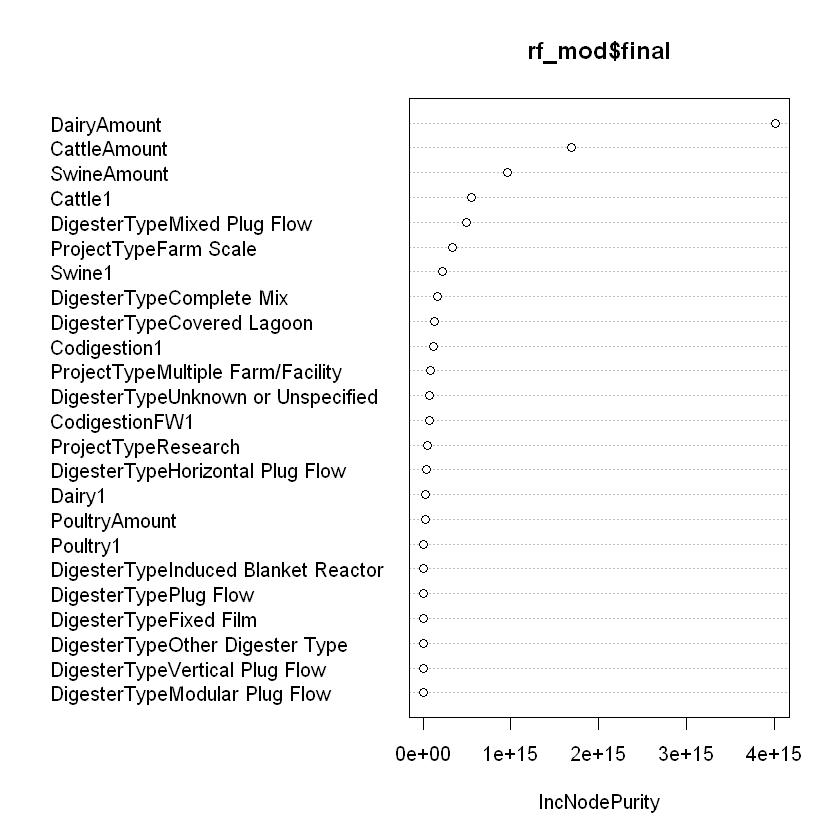

In [126]:
# Variable importance plot
varImpPlot(rf_mod$final)

### Gradient boosted machine model

In [151]:
# # We first train a random forest model
# set.seed(0)
# gbm_mod <- train(ElectricitykWhyr ~ ., data = df2[-14], 
#                  method = "gbm", 
#                  trControl = fitControl,
#                  tuneLength = 8)

In [129]:
#Model performance summary
gbm_mod

Stochastic Gradient Boosting 

280 samples
 12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 252, 252, 252, 252, 252, 252, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE     Rsquared   MAE    
  1                   50      4672464  0.4269948  2652750
  1                  100      4668143  0.4341310  2637344
  1                  150      4652120  0.4402696  2639945
  1                  200      4672382  0.4362923  2662673
  1                  250      4674321  0.4396526  2654593
  1                  300      4687526  0.4407526  2654001
  1                  350      4700743  0.4390312  2652132
  1                  400      4715813  0.4369953  2653742
  2                   50      4656226  0.4323917  2583365
  2                  100      4696606  0.4319160  2614509
  2                  150      4729497  0.4301628  2632039
  2                  200      4770488  0.4237440  2651932
  2   

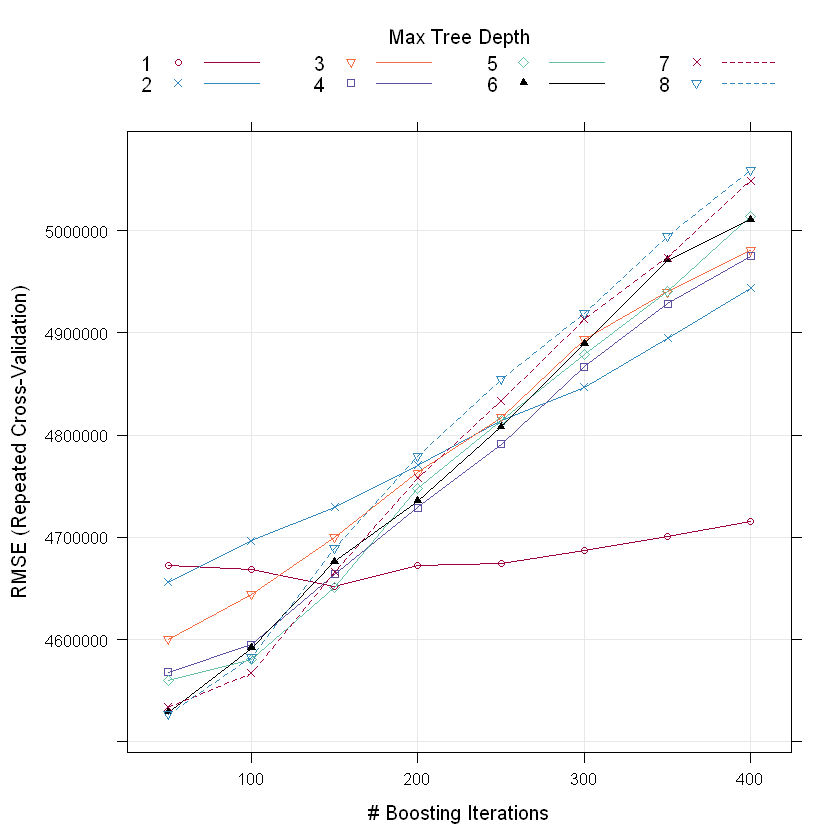

In [130]:
# Model training performance plot
plot(gbm_mod)

### Let's check if FW codigestion has any effect for the dairy farms

In [133]:
# Filter data to get only projects that treat dairy waste
df3 <- filter(df2,
             DairyAmount > 0)
df3 <- df3[c(1:2,8,11:14)]

In [139]:
# Train a random forest model
set.seed(0)
rf_mod <- train(ElectricitykWhyr ~ ., data = df3[c(-7,-3)], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [140]:
# Model performance
rf_mod

Random Forest 

209 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 188, 189, 188, 188, 188, 189, ... 
Resampling results across tuning parameters:

  mtry  RMSE     Rsquared   MAE    
   2    4691387  0.1515879  3203923
   4    4650912  0.1560878  3131945
   6    4656963  0.1593200  3131270
   8    4668786  0.1601563  3139875
  10    4679620  0.1599239  3150154
  12    4682395  0.1614475  3150926
  14    4686148  0.1608261  3152150
  16    4690209  0.1600160  3153022

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 4.

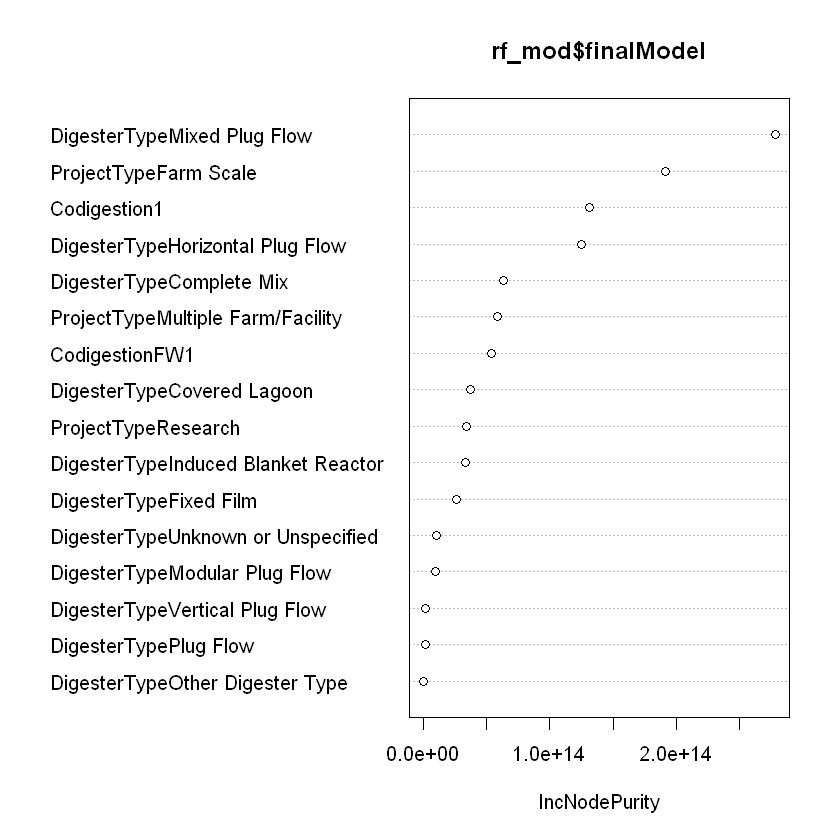

In [141]:
# Feature importance plot
varImpPlot(rf_mod$finalModel)

## 3. DEA on USA projects

In [142]:
# Create a new dataframe for the DEA and assign x and y variable values
x <- matrix(df3$DairyAmount)
y <- matrix(df3$ElectricitykWhyr)

In [143]:
# Run the DEA model (one input, one output, input-oriented)
e_vrs <- dea(x,y, RTS="vrs", ORIENTATION = "in")

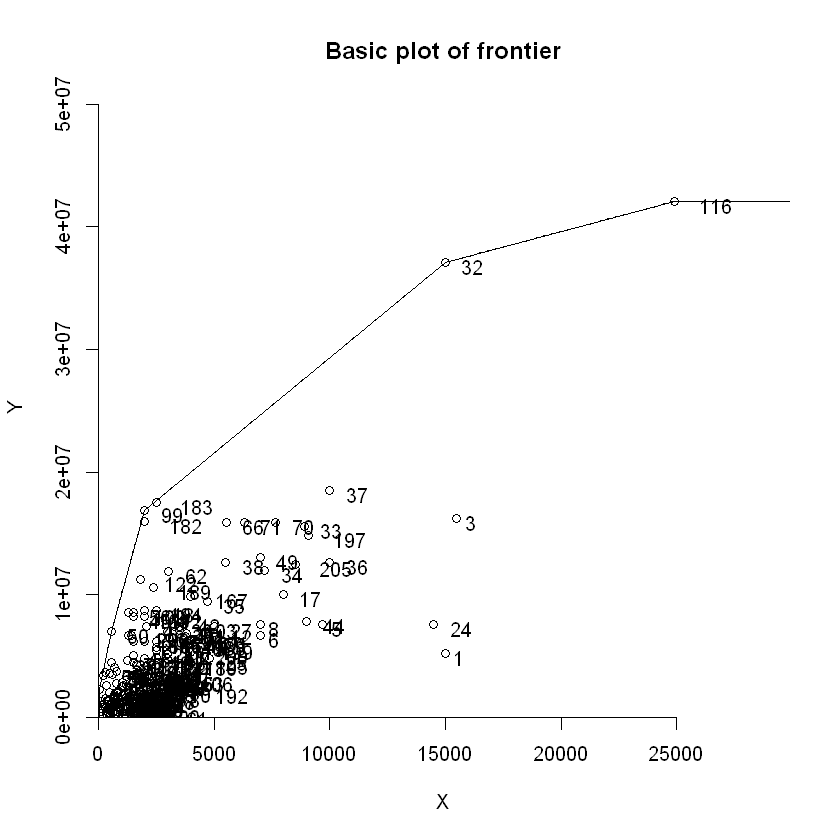

In [144]:
# Plot of different technologies with a title
dea.plot(x,y, txt=1:dim(x)[1],main="Basic plot of frontier")
dea.plot(x,y,RTS="vrs",add=TRUE,lty="dashed")

### Second stage of DEA: determinants of efficiency

In [145]:
#First we build a new df for regressing features on efficiency values
df4 <- df3
eff <- e_vrs$eff
df4$eff <- eff

In [146]:
str(df4)

'data.frame':	209 obs. of  8 variables:
 $ ProjectType         : Factor w/ 4 levels "Centralized/Regional",..: 2 2 2 2 2 3 2 2 2 2 ...
 $ DigesterType        : Factor w/ 12 levels "Anaerobic Sequencing Batch Reactor",..: 3 3 3 3 3 3 2 3 3 3 ...
 $ DairyAmount         : num  15000 4000 15500 1700 9700 ...
 $ Codigestion         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 2 1 ...
 $ CodigestionFW       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ElectricitykWhyr    : num  5256000 4467600 16206000 4204800 7600000 ...
 $ EmissionRedMetricTpy: num  138971 39353 108050 15014 82693 ...
 $ eff                 : num  0.0242 0.0699 0.1224 0.1479 0.0658 ...


In [147]:
# Efficiency model with cv and rf model
set.seed(0)
eff_mod_rf <- train(eff ~ ., data = df4[c(-3,-6,-7)], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [148]:
# Model performance summary
eff_mod_rf

Random Forest 

209 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 189, 188, 188, 188, 188, 189, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    0.1793693  0.2172054  0.1160678
   4    0.1771551  0.2289686  0.1136806
   6    0.1778368  0.2268909  0.1140955
   8    0.1784004  0.2273055  0.1143362
  10    0.1797224  0.2215174  0.1150411
  12    0.1801635  0.2196373  0.1153448
  14    0.1810418  0.2162102  0.1158452
  16    0.1814443  0.2159537  0.1159014

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 4.

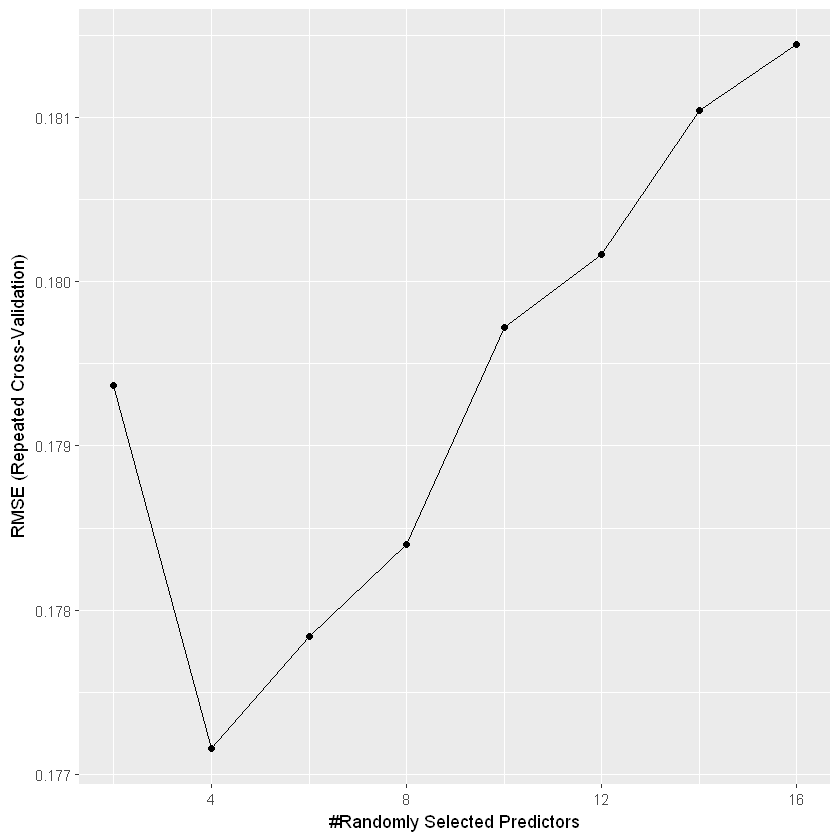

In [149]:
# Model training visualization
ggplot(eff_mod_rf)

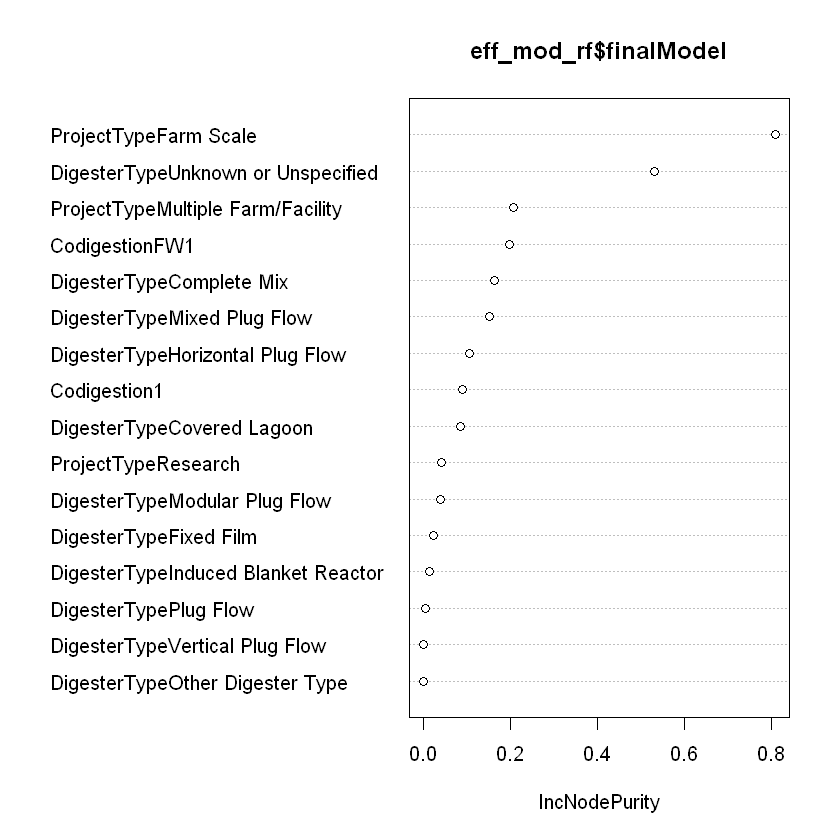

In [150]:
# Variable importance plot
varImpPlot(eff_mod_rf$finalModel)